## Importing the libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from sklearn.metrics import mean_absolute_error

import os

import warnings
warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import logging, sys
logging.disable(sys.maxsize)

plt.rcParams["figure.figsize"] = (10,7)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



## Get Data

### To download the historical price data of Nifty50 and try and predict the price of Nifty50. Use the below link address and wget to download the data



Note 

'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv'

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-06-19 13:40:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2022-06-19 13:40:37 (7.21 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [ ]:
# # Get the Nifty50 data from gdrive

# from google.colab import drive
# drive.mount('/content/gdrive')

# !cp '/content/gdrive/My Drive/NIFTY 50_Data.csv' 'Nifty_50_data.csv'

## Importing data with pandas

 

*   And because our data has a date component, we'll tell pandas to parse the dates using the **parse_dates** parameter passing it the name our of the date column ("Date").
*   To set the index as the date use the **index_col**



In [ ]:
# df = pd.read_csv('/content/Nifty_50_data.csv', 
#                  parse_dates = ['Date'],
#                  index_col = 'Date')
# df.head()



In [ ]:
# df.tail()

In [ ]:
# df.info()

## Structuring and Formatting data 


In [ ]:
# # include missing dates in time series data and interpolate 

# print(str(df.index.min())[:10], str(df.index.max())[:10])

# df_nifty = df['Close']
# idx = pd.date_range(str(df.index.min())[:10], str(df.index.max())[:10])
# df_nifty.index = pd.DatetimeIndex(df_nifty.index)
# df_nifty = df_nifty.reindex(idx, fill_value=np.nan)
# df_nifty = df_nifty.interpolate(method = 'nearest').round()
# nifty_df = pd.DataFrame(df_nifty)
# nifty_df

In [ ]:
# df['Close'].plot()

In [ ]:
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', 
                 parse_dates = ['Date'],
                 index_col = 'Date')
df.rename(columns={'Closing Price (USD)':'Close'}, inplace= True)
df.head()

,Currency,Close,24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df = df.drop(['Currency', '24h Open (USD)',	'24h High (USD)',	'24h Low (USD)'], axis = 1)
df.head()

,Close
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
df.tail()

,Close
Date,
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255
2021-05-17,45604.615754
2021-05-18,43144.471291


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2787 non-null   float64
dtypes: float64(1)
memory usage: 43.5 KB




We've collected the historical price of Bitcoin for the past ~8 years but there's only 2787 total samples. 
This is something you'll run into with time series data problems. Often, the number of samples isn't as large as other kinds of data.

**NOTE**

The frequency at which a time series value is collected is often referred to as seasonality. This is usually mesaured in number of samples per year. For example, collecting the price of Bitcoin once per day would result in a time series with a seasonality of 365.



## Time Series Components

### Combining Time Series Components
A series is thought to be an aggregate or combination of these 
four components. 

*   **Level**: The average value in the series.
*   **Trend**: The increasing or decreasing value in the series.
*   **Seasonality**: The repeating short-term cycle in the series.
*   **Noise**: The random variation in the series.

All series have a level and noise. The trend and seasonality components are optional. It is helpful to think of the components as combining either additively or multiplicatively.

### Additive Model
An additive model suggests that the components are added together as follows:

**y(t) = Level + Trend + Seasonality + Noise**

An additive model is linear where changes over time are consistently made by the same amount. A linear trend is a straight line. A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).

### Multiplicative Model
A multiplicative model suggests that the components are multiplied together as follows:

y(t) = Level * Trend * Seasonality * Noise **bold text**

A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time. A nonlinear trend is a curved line. A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.

### Plotting Closing Price of Bitcoin 

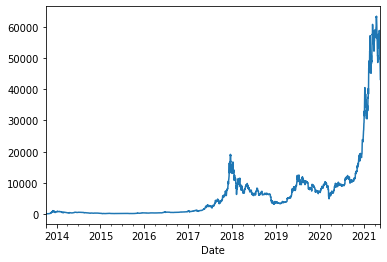

In [ ]:
df['Close'].plot()

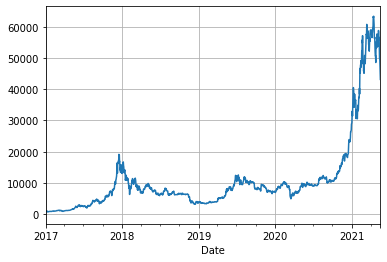

In [ ]:
# Limiting the plot to specific date range
df['Close'].plot(xlim = ('2017-01-01', '2021-05-18'), grid = True)

In [ ]:
df.index[:35]

DatetimeIndex(['2013-10-01', '2013-10-02', '2013-10-03', '2013-10-04',
               '2013-10-05', '2013-10-06', '2013-10-07', '2013-10-08',
               '2013-10-09', '2013-10-10', '2013-10-11', '2013-10-12',
               '2013-10-13', '2013-10-14', '2013-10-15', '2013-10-16',
               '2013-10-17', '2013-10-18', '2013-10-19', '2013-10-20',
               '2013-10-21', '2013-10-22', '2013-10-23', '2013-10-24',
               '2013-10-25', '2013-10-26', '2013-10-27', '2013-10-28',
               '2013-10-29', '2013-10-30', '2013-10-31', '2013-11-01',
               '2013-11-02', '2013-11-03', '2013-11-04'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2787 non-null   float64
dtypes: float64(1)
memory usage: 43.5 KB


### Checking the seasonal decomposition for trend and seasonality




**Note**

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

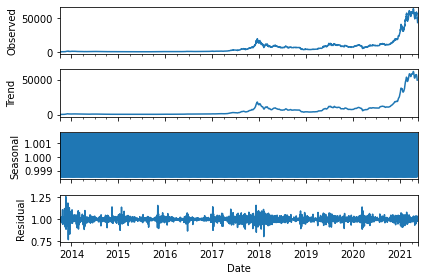

In [ ]:
# import statsmodels
# result =  statsmodels.tsa.seasonal.seasonal_decompose(df['Close'], model='additive', period = 1)
result = seasonal_decompose(df['Close'], model='multiplicative')
result.plot()
plt.show()

 ** Note **

*   Based on the above plot we can see that there is no seasonality 
and has positive trend. 
*   The residuals are also interesting, showing periods of high variability in the series.






## **White Noise**


* White noise is an important concept in time series forecasting.

* If a time series is white noise, it is a sequence of random numbers and cannot be predicted. If the series of forecast errors are not white noise, it suggests improvements could be made to the predictive model.

  https://machinelearningmastery.com/white-noise-time-series-python/



### **Check if data is white noise**

Your time series is probably NOT white noise if one or more of the following conditions are true:

* Is the mean/level non-zero?
* Does the mean/level change over time?
* Does the variance change over time?
* Do values correlate with lag values?

**Some tools that you can use to check if your time series is white noise are:**

* Create a line plot. Check for gross features like a changing mean, variance, or obvious relationship between lagged variables.
* Calculate summary statistics. Check the mean and variance of the whole series against the mean and variance of meaningful contiguous(neighbouring) blocks of values in the series (e.g. days, months, or years).
* Create an autocorrelation plot. Check for gross correlation between lagged variables.

In [ ]:
len(df)

2787

In [ ]:
df.describe()

,Close
count,2787.000000
mean,6529.845141
std,10887.847444
min,108.584830
25%,460.087500
50%,2780.182500
75%,8506.923720
max,63346.789035


**Note**

We can see that the series does not have mean close to zero or standard deviation close to 1 which is a good sign and shows that the series does not have white noise.

It might be more interesting to split the series in half and calculate and compare the summary statistics for each half. We would expect to see a 0 mean and 1 standard deviation for each sub-series if the series has white noise.

Lets now split the data or take a chunks of data and check if the mean and variance if it changes over time to see if the series has white noise. 

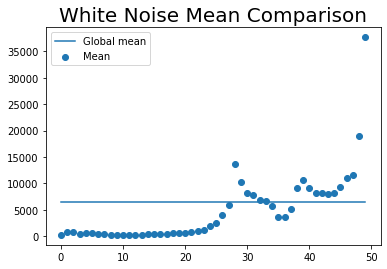

In [ ]:
white_noise_chunks = np.split(df[:2700], 50)
means, stds = [], []

# Get the mean and std values for every chunk
for chunk in white_noise_chunks:
    means.append(np.mean(chunk))
    stds.append(np.std(chunk))
    
    
# Plot
plt.title('White Noise Mean Comparison', size=20)
plt.plot(np.arange(len(means)), [df.mean()] * len(means), label='Global mean', lw=1.5)
plt.scatter(x=np.arange(len(means)), y=means, label='Mean')
plt.legend()

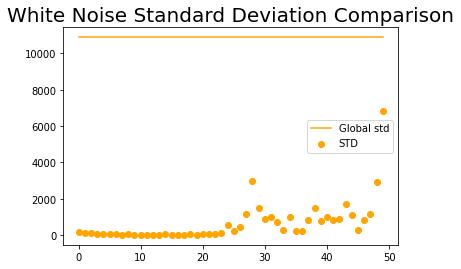

In [ ]:
plt.title('White Noise Standard Deviation Comparison', size=20)
plt.plot(np.arange(len(stds)), [df.std()] * len(stds), label='Global std', lw=1.5, color='orange')
plt.scatter(x=np.arange(len(stds)), y=stds, label='STD', color='orange')
plt.legend()

**Note**

Creating a plot to see if the series has regular intervals of random data.

We can also create a histogram and confirm the distribution is Gaussian.Indeed, the histogram shows the tell-tale bell-curve shape. Series with white noise would show a Gaussian curve with bell shape. 

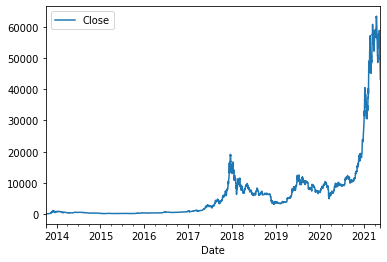

In [ ]:
df.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe1966baa90>]],
      dtype=object)

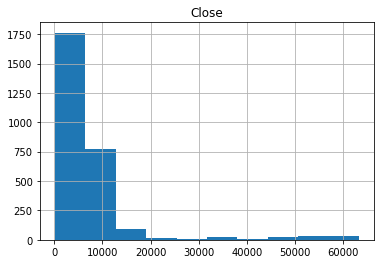

In [ ]:
df.hist()

**Note**

* Finally, we can create a correlogram and check for any autocorrelation with lag variables.

* 
We can also create ACF plots to check the dependecy of lags with the curent observation 


An autocorrelation plot shows the correlation between a time series with itself, lagged by a specific number of periods.

Autocorrelation plots also include a shaded area that represents confidence intervals. Anything inside the shaded area means that the correlation at that point isn’t statistically significant. Autocorrelation at lag 0 will have a value of 1, since the correlation is calculated between two identical time series.


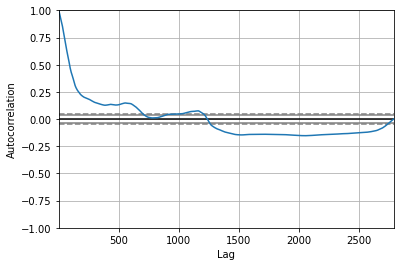

In [ ]:
autocorrelation_plot(df)
plt.show()

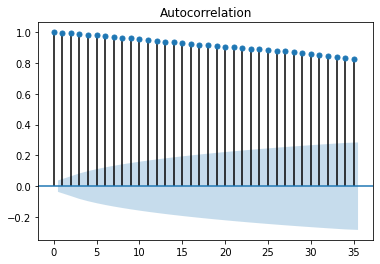

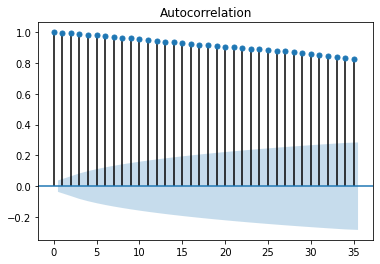

In [ ]:
plot_acf(df)

In [ ]:
# plot_pacf(nifty_df)

**Note**

As you can see, all lags are are outside the shaded area
And that concludes the white noise part of the series. 

In [ ]:
## ADFuller Test to determine if the series is a random walk
## the first order diff of series if shows white noise then its randomwalk
# https://towardsdatascience.com/how-to-detect-random-walk-and-white-noise-in-time-series-forecasting-bdb5bbd4ef81
# https://towardsdatascience.com/time-series-from-scratch-white-noise-and-random-walk-5c96270514d3
# https://machinelearningmastery.com/gentle-introduction-random-walk-times-series-forecasting-python/

# from statsmodels.tsa.stattools import adfuller

# results= adfuller(nifty_df['Close'])
# print('ADF Statistic: %f' % results[0])
# print('p-value: %f' % results[1])
# print('Critical Values:')
# for key, value in results[4].items():
# 	print('\t%s: %.3f' % (key, value))

In [ ]:
# plt.plot(nifty_df.diff())

In [ ]:
# plot_acf(nifty_df.diff())

In [ ]:
# autocorrelation_plot(nifty_df.diff)
# plt.show()

In [ ]:
# nifty_df.diff().describe()

In [ ]:
# white_noise_chunks = np.split(nifty_df.diff()[:8000], 100)
# means, stds = [], []

# # Get the mean and std values for every chunk
# for chunk in white_noise_chunks:
#     means.append(np.mean(chunk))
#     stds.append(np.std(chunk))
    
    
# # Plot
# plt.title('White Noise Mean and Standard Deviation Comparison', size=20)
# plt.plot(np.arange(len(means)), [nifty_df.diff().mean()] * len(means), label='Global mean', lw=1.5)
# plt.scatter(x=np.arange(len(means)), y=means, label='Mean')
# plt.plot(np.arange(len(stds)), [nifty_df.diff().std()] * len(stds), label='Global std', lw=1.5, color='orange')
# plt.scatter(x=np.arange(len(stds)), y=stds, label='STD', color='orange')
# plt.legend()

## Univariate and Multivariate

* Univariate time series data deals with one variable, for example, using the price of Nifty to predict the price of Nifty.

* Multivariate time series data deals with more than one variable, for example, predicting electricity demand using the day of week, time of year and number of houses in a region

## Splitting the Time Series Data (right way)

In [ ]:
timesteps = df.index.to_numpy()
prices = df["Close"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
# timesteps = nifty_df.index.to_numpy()
# prices = nifty_df["Close"].to_numpy()

# timesteps[:10], prices[:10]

In [ ]:
len(prices), len(timesteps)

(2787, 2787)

In [ ]:

# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

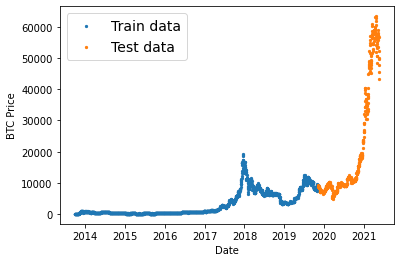

In [ ]:
# Plot correctly made splits
# plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Plot Function

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

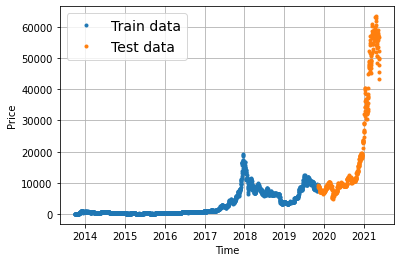

In [ ]:
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Metrics and Evaluations Function

Some of the common metrics for a time series forecast are given below. y

* R-Squared
* Mean Absolute Error
* Mean Absolute Percentage Error
* Mean Squared Error
* Root Mean Squared Error
* Normalized Root Mean Squared Error
* Weighted Absolute Percentage Error
* Weighted Mean Absolute Percentage Error


you can read them in details in link below.

https://analyticsindiamag.com/a-guide-to-different-evaluation-metrics-for-time-series-forecasting-models/


In [ ]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season


def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

## Structuring and Formatting Data (Part 2)


Windowing is a method to turn a time series dataset into supervised learning problem.

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (window=7) to predict the next single value (horizon=1) might look like:

Window for one week (univariate time series)

    [0, 1, 2, 3, 4, 5, 6] -> [7]

    [1, 2, 3, 4, 5, 6, 7] -> [8]

    [2, 3, 4, 5, 6, 7, 8] -> [9]

In [ ]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [ ]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [ ]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


## Making Train Test Split on Windows and Labels Function


In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

In [ ]:
len(train_labels[:-HORIZON-1]), len(y_train[WINDOW_SIZE:])

(2222, 2222)

## Modelling Chekpoint Function

In [ ]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model 1 : Base Model Dense


In [ ]:
## Base Model Dense

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Dense(128,activation = 'relu'),
    layers.Dense(128,activation = 'relu'),
    layers.Dense(128,activation = 'relu'),
    layers.Dense(1, activation ='linear')
], name = 'model_1_dense')

model_1.compile(loss = 'mae', 
                optimizer = 'adam', 
                metrics = ['mae'])

history_1 = model_1.fit(x = train_windows,
            y = train_labels,
            epochs = 100,
            verbose = 0,
            batch_size = 128,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_1.name)])

In [ ]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 619.9005 - mae: 619.9005


[619.9004516601562, 619.9004516601562]

In [ ]:
# Load in the best performing model
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 566.8790 - mae: 566.8790


[566.8790283203125, 566.8790283203125]

## Forecast Function

In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [ ]:
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8827.106, 8769.943, 9039.042, 8770.901, 8715.464, 8732.526,
        8659.861, 8505.373, 8442.771, 8517.143], dtype=float32)>)

In [ ]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 566.879,
 'mape': 2.5480661,
 'mase': 0.99584943,
 'mse': 1155784.9,
 'rmse': 1075.0743}

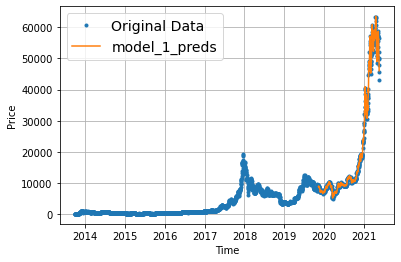

In [ ]:
offset = 0
# plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
# plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps, prices, start = offset, label = "Original Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

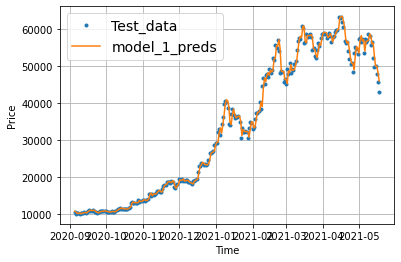

In [ ]:
offset = 300
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## Loss Curves Function


In [ ]:
def loss_curves(history):
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

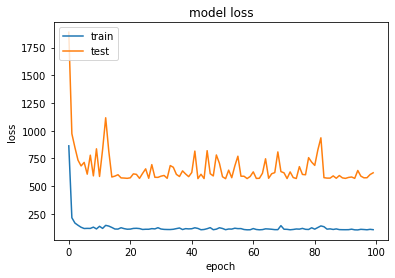

In [ ]:
loss_curves(history_1)

## Model 2: LSTM 

In [ ]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu", return_sequences = True)(x)
x = layers.LSTM(128, activation="relu", return_sequences = True)(x)
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
history_5 = model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [ ]:
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 580.6100


580.6099853515625

In [ ]:
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8902.902 , 8769.48  , 8957.952 , 8827.71  , 8772.3955, 8712.019 ,
       8682.526 , 8543.914 , 8461.051 , 8498.697 ], dtype=float32)>

In [ ]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 580.61005,
 'mape': 2.6319785,
 'mase': 1.019971,
 'mse': 1208065.8,
 'rmse': 1099.1205}

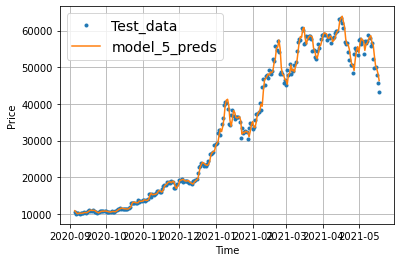

In [ ]:
offset = 300
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_5_preds, start=offset, format="-", label="model_5_preds")

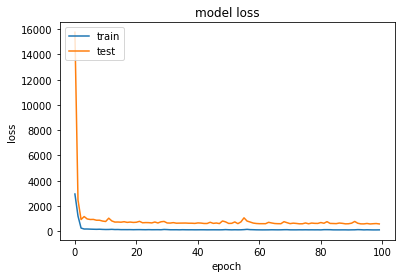

In [ ]:
loss_curves(history_5)

In [ ]:
# ensemble_models = [model_1, model_5]
# ensemble_models

# def make_ensemble_preds(ensemble_models, data):
#   ensemble_preds = []
#   for model in ensemble_models:
#     preds = model.predict(data) # make predictions with current ensemble model
#     ensemble_preds.append(preds)
#   return tf.constant(tf.squeeze(ensemble_preds))

# ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
#                                      data=test_windows)
# ensemble_preds

# ensemble_results = evaluate_preds(y_true=y_test[2:],
#                                   y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
# ensemble_results

# pd.DataFrame({
#               "horizon_1_window_7_DENSE": model_1_results["mae"], 
#                 "horizon_1_window_7_LSTM": model_5_results["mae"],
#               "horizon_1_window_7_ENSEMBLE": ensemble_results["mae"]
#               }, index=["mae"]).plot(figsize=(10, 7), kind="bar");

In [ ]:
# len(ensemble_preds[0]), len(ensemble_preds[1])
# len(np.median(ensemble_preds, axis=0))
# len(y_test)

## Model 3 : N-Beats


### Preparing data for the N-BEATS algorithm using tf.data

In [ ]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [ ]:
df.head()

,Close
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Close+{i+1}"] = bitcoin_prices_nbeats["Close"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Close,Close+1,Close+2,Close+3,Close+4,Close+5,Close+6,Close+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [ ]:
X = bitcoin_prices_nbeats.dropna().drop("Close", axis=1)
y = bitcoin_prices_nbeats.dropna()["Close"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Trying out previous model on modified data


In [ ]:
## Base Model Dense

tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    layers.Dense(128,activation = 'relu'),
    layers.Dense(128,activation = 'relu'),
    layers.Dense(128,activation = 'relu'),
    layers.Dense(1, activation ='linear')
], name = 'model_2_dense')

model_2.compile(loss = 'mae', 
                optimizer = 'adam', 
                metrics = ['mae'])

history_2 = model_2.fit(train_dataset,
            epochs = 100,
            verbose = 0,
            batch_size = 128,
            validation_data = test_dataset,
            callbacks = [create_model_checkpoint(model_name = model_2.name)])

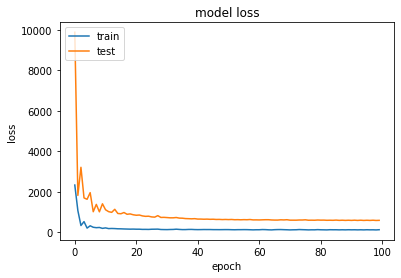

In [ ]:
loss_curves(history_2)

In [ ]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_dataset)

1/1 [==============================] - 0s 101ms/step - loss: 585.4970 - mae: 585.4970


[585.4970092773438, 585.4970092773438]

In [ ]:
model_2_preds = make_preds(model_2, test_dataset)
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8909.276, 8828.334, 8988.707, 8778.18 , 8764.121, 8722.803,
       8671.104, 8574.676, 8453.711, 8520.249], dtype=float32)>

In [ ]:
model_2_results = evaluate_preds(y_test, model_2_preds)
model_2_results

{'mae': 585.497,
 'mape': 2.6438901,
 'mase': 1.0285561,
 'mse': 1235332.6,
 'rmse': 1111.4552}

In [ ]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu", return_sequences = True)(x)
x = layers.LSTM(128, activation="relu", return_sequences = True)(x)
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_3 = tf.keras.Model(inputs=inputs, outputs=output, name="model_3_lstm")

# Compile model
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
history_3 = model_3.fit(train_dataset,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=test_dataset,
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

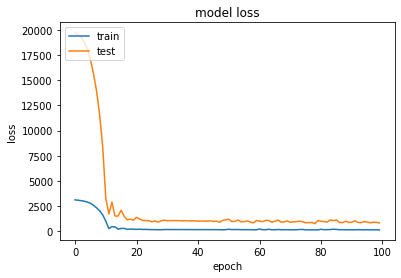

In [ ]:
loss_curves(history_3)

In [ ]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_lstm/")
model_3.evaluate(test_dataset)

1/1 [==============================] - 0s 370ms/step - loss: 768.7718


768.7717895507812

In [ ]:
model_3_preds= make_preds(model_3, test_dataset)
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9186.882, 9133.177, 9147.074, 8981.908, 8948.307, 8891.164,
       8793.598, 8749.481, 8684.72 , 8643.108], dtype=float32)>

In [ ]:
model_3_results = evaluate_preds(y_test, model_3_preds)
model_3_results

{'mae': 768.7718,
 'mape': 3.4696374,
 'mase': 1.3505191,
 'mse': 2018388.5,
 'rmse': 1420.7}

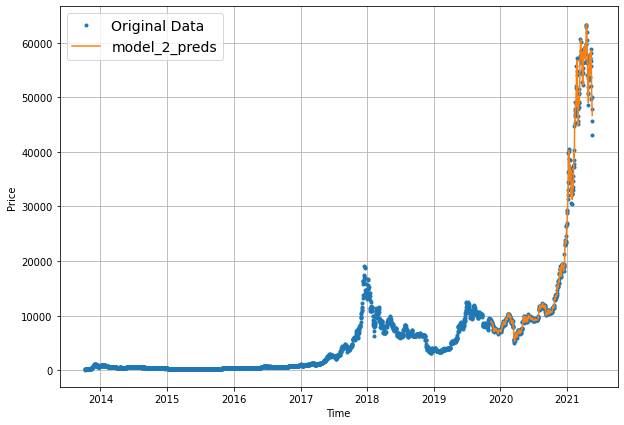

In [ ]:
offset = 0
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(X.index, y, label="Original Data")
plot_time_series(timesteps=X_test.index, values=model_2_preds, start=offset, format="-", label="model_2_preds")

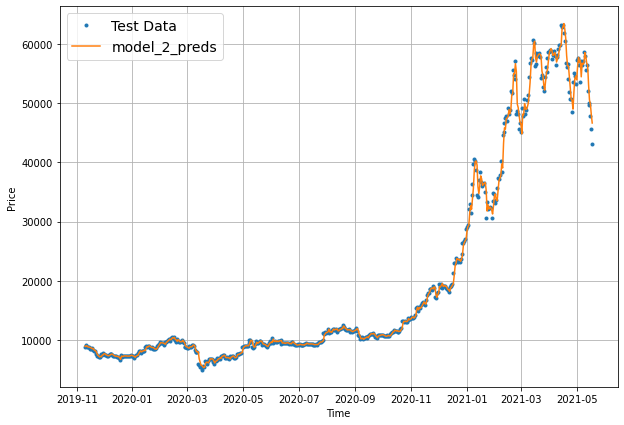

In [ ]:
offset = 0
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(X_test.index, y_test, label="Test Data")
plot_time_series(timesteps=X_test.index, values=model_2_preds, start=offset, format="-", label="model_2_preds")

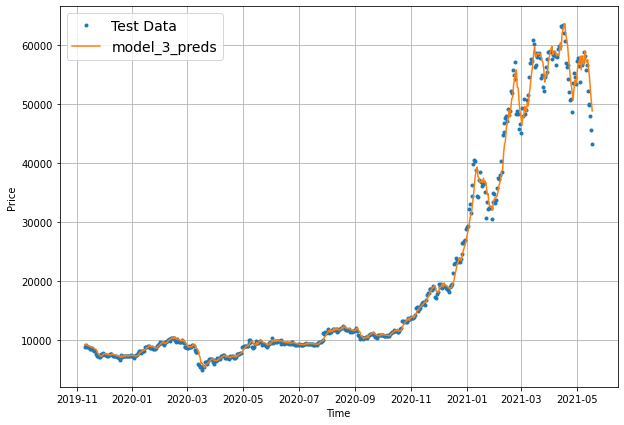

In [ ]:
offset = 0
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(X_test.index, y_test, label="Test Data")
plot_time_series(timesteps=X_test.index, values=model_3_preds, start=offset, format="-", label="model_3_preds")

###  Building and Testing the N-Beats Block Layer



In [ ]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.1197367   0.5126637   0.61159366 -0.4715315  -0.8028359  -0.15500176
  0.68190247]
Forecast: 0.38599205017089844


### Settign up HYPERPARAMETERS for NBEATS

In [ ]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON

THETA_SIZE = INPUT_SIZE + HORIZON

### Getting Ready for Residual Connections


In [ ]:
# Make Tensors and example operation for addition and subtaction with tensors, layers.add and layers.subtract

tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

tensor_1, tensor_2

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>)

In [ ]:
#subtract
subtracted = layers.subtract([tensor_1, tensor_2])

#add
added = layers.add([tensor_1, tensor_2])

subtracted, added

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28], dtype=int32)>)

### Building, Compiling and Fitting NBEATS

1. Setup an Instance of NBeats Block Layer using "NBeatsBlock" 
2. Create an Input Layer for NBeats Stack (we would be using the Functional API)
3. Make the initial Backcast and Forecast for the model with the layer in (1)
4. Use for loop to create stacks of block layers
5. Use the NbeatsBlock class within the for loop in (4) to create blocks which return the backcast and block level forecast
6. Create the Double Residual Stacking using layers.add and layers.subtract
7. Put the model inputs and outputs together using tf.keras.Model()
8. Compile the model with MAE loss and Adam Optimizer
9. Fit the model for 5000 Epochs and use callbacks for early stopping and reduce LR on Plateau






In [ ]:
%%time

tf.random.set_seed(42)

# Setup an Instance of NBeats Block Layer using "NBeatsBlock"
nbeats_block_layer = NBeatsBlock(input_size = INPUT_SIZE,
                                 theta_size = THETA_SIZE,
                                 horizon = HORIZON,
                                 n_neurons = N_NEURONS,
                                 n_layers = N_LAYERS,
                                 name = "InitialBlock")

#Create an input for nbeats stack
stack_input = layers.Input(shape = (INPUT_SIZE), name = "stack_input")

# Create initial backcast and forecast input (backward prediction and forward prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# Create a for loop for stacks of block layes
for i, _ in enumerate(range(N_STACKS-1)):

  # use the nbeats block to calculate the backcast and forecast
  backcast, block_forecast = NBeatsBlock(
      input_size = INPUT_SIZE,
      theta_size = THETA_SIZE,
      horizon = HORIZON,
      n_neurons = N_NEURONS,
      n_layers = N_LAYERS,
      name = f"NBeatsBlock_{i}"
  )(residuals)  # pass in the residuals as input

  # create the double residual stacking using tf.layers.add and tf.layers.subtract
  residuals = layers.subtract([residuals,backcast], name = f"subtract_{i}")
  forecast =layers.add([forecast, block_forecast], name = f"add_{i}")

# Put stack model together
model_6 = tf.keras.Model(inputs = stack_input,
                         outputs = forecast,
                         name = "model_7_nbeats")

# Compile model with MAE loss
model_6.compile(loss = "mae",
                optimizer = "adam")   

# Fit the model with early stopping and LR plateau
history_6 = model_6.fit(train_dataset,
                        epochs = N_EPOCHS,
                        validation_data = test_dataset,
                        verbose = 0,
                        callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                                      patience = 200,
                                                                      restore_best_weights = True),
                                     tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                                                          factor = 0.1,
                                                                          patience = 100,
                                                                          verbose = 1)])




Epoch 876: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1300: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1400: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 3min 53s, sys: 7.23 s, total: 4min 1s
Wall time: 4min 41s


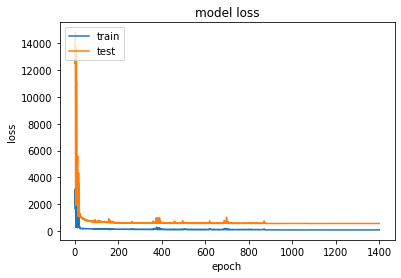

In [ ]:
loss_curves(history_6)

In [ ]:
model_6.evaluate(test_dataset)

1/1 [==============================] - 0s 20ms/step - loss: 576.9384


576.9384155273438

In [ ]:
model_6_preds = make_preds(model_6, test_dataset)
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8843.784 , 8775.991 , 9019.274 , 8738.393 , 8746.173 , 8747.784 ,
       8660.936 , 8479.6045, 8484.671 , 8506.627 ], dtype=float32)>

In [ ]:
model_6_results = evaluate_preds(y_test, model_6_preds)
model_6_results

{'mae': 576.9384,
 'mape': 2.605957,
 'mase': 1.013521,
 'mse': 1167544.4,
 'rmse': 1080.5297}

### Plot the nbeats model

In [ ]:
# Plot the nbeats model using tensorflow plot
from tensorflow.keras.utils import plot_model
# plot_model(model_6)

## Model 4: Ensemble Model Experiment (Optional)

### Setting up custom loss functions

1. SMAPE
2. MASE

In [ ]:

class SMAPE(keras.losses.Loss):
    def __init__(self, epsilon=0.1, name="smape"):
        super().__init__(name=name)
        self.epsilon = epsilon

    def call(self, y_true, y_pred):
        summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + self.epsilon, 0.5 + self.epsilon)
        smape = K.abs(y_pred - y_true) / summ * 2.0
        return smape


class MASE(keras.losses.Loss):
    def __init__(self, y_train, name="MASE"):
        super().__init__(name=name)
        self.y_train = y_train

    def call(self, y_true, y_pred):
        e_t = y_true - y_pred
        scale = mean_absolute_error(self.y_train[1:], self.y_train[:-1])
        return tf.math.reduce_mean(K.abs(e_t / scale))


### Preparing data for ensemble modelling

In [ ]:
def create_train_test_datasets(df, WINDOW_SIZE):

  #create Windows based on Window Size
  bitcoin_prices_nbeats = df.copy()
  for i in range(WINDOW_SIZE):
    bitcoin_prices_nbeats[f"Close+{i+1}"] = bitcoin_prices_nbeats["Close"].shift(periods=i+1)
  bitcoin_prices_nbeats = bitcoin_prices_nbeats.dropna()

  # Separate Dependent and Independent Variables
  X = bitcoin_prices_nbeats.dropna().drop("Close", axis=1)
  y = bitcoin_prices_nbeats.dropna()["Close"]
  print(f"Window size : {WINDOW_SIZE}, Shape of X : {X.shape}, Shape of y : {y.shape}")

  # Make train and test sets
  split_size = int(len(X) * 0.8)
  X_train, y_train = X[:split_size], y[:split_size]
  X_test, y_test = X[split_size:], y[split_size:]


  # 1. Turn train and test arrays into tensor Datasets
  train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
  train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

  test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
  test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

  # 2. Combine features & labels
  train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
  test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

  # 3. Batch and prefetch for optimal performance
  BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
  train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  return train_dataset, test_dataset, y_train

### Setting up parameters for ENSEMBLE NBEATS MODEL

In [ ]:
HORIZON = 1
WINDOW_SIZES = [2,3,4,5,6,7]
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

### Training and Fitting data on Ensemble Model 

In [ ]:
%%time
ensemble_models = []
for pos, WINDOW_SIZE in enumerate(WINDOW_SIZES):

  train_dataset, test_dataset, y_train = create_train_test_datasets(df, WINDOW_SIZE)
  # LOSS_FNS = [MASE(y_train), SMAPE(), "mape"]

  LOSS_FNS = ["mae", "mse", "mape"]
  INPUT_SIZE = WINDOW_SIZE * HORIZON
  THETA_SIZE = INPUT_SIZE + HORIZON
  
  for loss_function in LOSS_FNS:
    print(f"Model {pos+1} : Optimizing model by reducing: {loss_function} for input size (Windows * Horizon) {INPUT_SIZE}")

    # Setup an Instance of NBeats Block Layer using "NBeatsBlock"
    nbeats_block_layer = NBeatsBlock(input_size = INPUT_SIZE,
                                    theta_size = THETA_SIZE,
                                    horizon = HORIZON,
                                    n_neurons = N_NEURONS,
                                    n_layers = N_LAYERS,
                                    name = "InitialBlock")

    #Create an input for nbeats stack
    stack_input = layers.Input(shape = (INPUT_SIZE), name = "stack_input")

    # Create initial backcast and forecast input (backward prediction and forward prediction)
    residuals, forecast = nbeats_block_layer(stack_input)

    # Create a for loop for stacks of block layes
    for i, _ in enumerate(range(N_STACKS-1)):

      # use the nbeats block to calculate the backcast and forecast
      backcast, block_forecast = NBeatsBlock(
          input_size = INPUT_SIZE,
          theta_size = THETA_SIZE,
          horizon = HORIZON,
          n_neurons = N_NEURONS,
          n_layers = N_LAYERS,
          name = f"NBeatsBlock_{i}"
      )(residuals)  # pass in the residuals as input

      # create the double residual stacking using tf.layers.add and tf.layers.subtract
      residuals = layers.subtract([residuals,backcast], name = f"subtract_{i}")
      forecast =layers.add([forecast, block_forecast], name = f"add_{i}")

    # Put stack model together
    model = tf.keras.Model(inputs = stack_input,
                            outputs = forecast,
                            name = "model_nbeats_ensemble")

    # Compile model with MAE loss
    model.compile(loss = loss_function,
                    optimizer = "adam")   

    # Fit the model with early stopping and LR plateau
    history = model.fit(train_dataset,
                            epochs = N_EPOCHS,
                            validation_data = test_dataset,
                            verbose = 0,
                            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                                          patience = 200,
                                                                          restore_best_weights = True),
                                        tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                                                              factor = 0.1,
                                                                              patience = 100,
                                                                              verbose = 1)])
    
    ensemble_models.append(model)


    

                      


Window size : 2, Shape of X : (2785, 2), Shape of y : (2785,)
Model 1 : Optimizing model by reducing: mae for input size (Windows * Horizon) 2

Epoch 322: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 422: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Model 1 : Optimizing model by reducing: mse for input size (Windows * Horizon) 2

Epoch 358: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


In [ ]:
ensemble_models

In [ ]:
# Create a list of ensemble predictions
from itertools import repeat
test_datasets = []
for pos, WINDOW_SIZE in enumerate(WINDOW_SIZES):

  train_dataset, test_dataset, y_train = create_train_test_datasets(df, WINDOW_SIZE)
  test_datasets.extend(repeat(test_dataset, 3))


test_datasets

In [ ]:
def make_ensemble_preds(ensemble_models, test_datasets):
  ensemble_preds = []
  for i in range(len(ensemble_models)):
    preds = make_preds(ensemble_models[i], test_datasets[i])
    if len(preds) == len(y_test):
      ensemble_preds.append(preds)
    else:
      ensemble_preds.append(preds[:-1])
  return tf.constant(tf.squeeze(ensemble_preds))


In [ ]:
ensemble_preds = make_ensemble_preds(ensemble_models, test_datasets)
ensemble_preds

In [ ]:
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.mean(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results